In [1]:
import pandas as pd
import torch
import numpy as np
import networkx as nx
import warnings
warnings.filterwarnings('ignore')
import csv
import random
import os
import torch_geometric.transforms as T
from torch_geometric.datasets.dblp import DBLP
from littleballoffur import ForestFireSampler
import matplotlib.pyplot as plt
import time

In [2]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
data

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057]
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1]
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

In [3]:
def feature_selection(df_sampled):
    col_sum = df_sampled.sum(axis=0)
    sorted_colsum = sorted(col_sum, reverse=True)
    index_list = []
    for i in sorted_colsum[:50]:
        index_list.append(list(col_sum).index(i))
    imp_feat = df_sampled[index_list]
    return imp_feat

In [4]:
#Original author node features
author = data['author'].x.tolist()
author_df = pd.DataFrame(author)
author_df['class'] = data['author'].y.tolist()
author_df

,0,1,2,3,4,5,6,7,8,9,...,325,326,327,328,329,330,331,332,333,class
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
author_class0 = author_df[author_df['class'] == 0].drop(['class'], axis = 1)
author_class0 = author_class0.reset_index(drop=True)
author_class0 = feature_selection(author_class0)
author_class0

,63,64,295,222,65,221,23,296,162,88,...,22,22,251,9,137,137,124,13,13,44
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1193,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1194,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
author_class1 = author_df[author_df['class'] == 1].drop(['class'], axis = 1)
author_class1= author_class1.reset_index(drop=True)
author_class1 = feature_selection(author_class1)
author_class1

,63,170,321,23,39,152,88,35,15,65,...,77,77,77,302,80,80,185,314,64,64
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
741,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
742,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
743,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
author_class2 = author_df[author_df['class'] == 2].drop(['class'], axis = 1)
author_class2= author_class2.reset_index(drop=True)
author_class2 = feature_selection(author_class2)
author_class2

,152,23,321,148,228,295,15,15,296,11,...,83,72,188,21,21,21,21,21,173,60
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1105,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1106,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1107,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
author_class3 = author_df[author_df['class'] == 3].drop(['class'], axis = 1)
author_class3= author_class3.reset_index(drop=True)
author_class3 = feature_selection(author_class3)
author_class3

,242,135,23,321,253,329,302,222,81,295,...,88,206,206,101,106,106,106,151,151,97
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
#Original paper node features
paper = data['paper'].x.tolist()
paper_df = pd.DataFrame(paper)
paper_df= paper_df.reset_index(drop=True)
paper_df = feature_selection(paper_df)
paper_df

,11,31,950,955,3074,4065,2081,2358,2338,1866,...,3691,3703,3969,1330,2161,3444,1201,1057,2967,3430
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14323,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14324,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14325,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14326,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Original paper node features
term = data['term'].x.tolist()
term_df = pd.DataFrame(term)
term_df = term_df.reset_index(drop=True)
term_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.69241,-0.465920,1.154000,0.066483,-0.676250,0.693760,0.53680,0.206780,0.12607,-0.36763,...,1.32870,0.074684,-0.34136,0.873600,-0.065725,-0.780720,0.902000,0.917840,0.19945,-0.63601
1,1.20310,-0.400280,0.073991,1.041500,0.051753,0.411660,-0.98656,-0.794660,0.36033,0.54428,...,0.38339,-0.572190,-0.16915,0.139840,-0.774300,-0.061819,0.218870,1.326200,-0.33245,0.81980
2,0.37481,0.573140,0.480170,-0.056679,0.704740,0.715910,0.32591,-0.099446,0.51029,0.64193,...,0.74200,-0.163610,0.44295,0.400600,-0.235400,-0.276530,-0.203020,1.152200,0.60099,-0.43094
3,0.54148,-0.419840,-0.334260,-0.412010,0.112200,1.047600,0.47449,-0.751110,0.40817,0.74477,...,0.45971,-0.064420,-0.27582,1.021800,-0.037676,-0.405910,1.231400,0.472220,0.69127,0.37195
4,0.16408,0.927990,-1.573400,-0.859870,0.369720,0.852800,0.20269,-0.620400,-1.00010,0.29585,...,0.66077,-0.952820,-0.36583,1.758900,-0.497820,0.599950,0.756170,1.384800,-0.11633,-0.62254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7718,0.41800,0.249680,-0.412420,0.121700,0.345270,-0.044457,-0.49688,-0.178620,-0.00066,-0.65660,...,-0.29871,-0.157490,-0.34758,-0.045637,-0.442510,0.187850,0.002785,-0.184110,-0.11514,-0.78581
7719,-1.01450,1.239400,-1.618500,-1.033600,-0.056811,0.270890,-0.38817,-0.353350,-0.51784,1.10460,...,0.97806,0.158320,-0.54189,-0.186700,-0.334690,0.391300,0.524110,-0.059546,-0.78882,-0.71343
7720,0.41800,0.249680,-0.412420,0.121700,0.345270,-0.044457,-0.49688,-0.178620,-0.00066,-0.65660,...,-0.29871,-0.157490,-0.34758,-0.045637,-0.442510,0.187850,0.002785,-0.184110,-0.11514,-0.78581
7721,0.17239,-0.272270,-1.336800,1.170600,-0.621270,-0.528470,1.32210,0.145990,-0.15398,-1.24660,...,-0.76113,-0.583970,-0.13828,0.907620,-0.114690,-0.746190,0.723290,-0.088101,0.02252,0.11660


Load Dataset

In [11]:
df_nodes = pd.read_table(('dblp_node.dat'),sep= ' ', names=['node_id', 'node_name', 'node_type'],encoding='latin-1')
df_nodes

,node_id,node_name,node_type
0,0,A,1
1,1,A,1
2,2,A,1
3,3,A,1
4,4,A,1
...,...,...,...
11235,11235,C,3
11236,11236,C,3
11237,11237,C,3
11238,11238,C,3


In [12]:
df_nodes_author = df_nodes[df_nodes['node_type'] == 1]
df_nodes_author

,node_id,node_name,node_type
0,0,A,1
1,1,A,1
2,2,A,1
3,3,A,1
4,4,A,1
...,...,...,...
4596,4596,A,1
4597,4597,A,1
4598,4598,A,1
4599,4599,A,1


In [13]:
df_edges = pd.read_table(('dblp_link.dat'),sep= ' ', names=['source', 'target'])
df_edges

,source,target
0,4601,1435
1,4601,1950
2,4601,2457
3,4601,2458
4,4601,2459
...,...,...
36640,7588,7639
36641,7588,7979
36642,7588,8084
36643,7588,8143


Create graph from dataset

In [14]:
G = nx.from_pandas_edgelist(
    df_edges,
    create_using=nx.Graph()
)

Add node features to graph from the dataset

In [15]:
dblp_node_features = df_nodes[['node_id','node_type']]
nodes_attr = dblp_node_features.set_index('node_id').to_dict(orient = 'index')
nx.set_node_attributes(G, nodes_attr)

In [16]:
def remap_indices(G):
    val_list = [*range(0, G.number_of_nodes(), 1)]
    return dict(zip(G,val_list)) 

In [17]:
def add_node_class(G):
    for n in G.nodes:
        node_type = G.nodes[n]["node_type"] 
        if node_type == 1:
            node_class = random.choice([0, 1, 2, 3])
            if node_class == 0:
                
                G.nodes[n]["class"] = node_class

            elif node_class == 1:
                G.nodes[n]["class"] = node_class

            elif node_class == 2:                 
                G.nodes[n]["class"] = node_class
                
            elif node_class == 3:     
                G.nodes[n]["class"] = node_class
    return G

In [19]:
def add_node_features(G):
    for n in G.nodes:
        node_type = G.nodes[n]["node_type"] 
        print(node_type)
        
        if node_type == 0:
            node_id = n
            paper_node_feature = paper_df.loc[int(node_id), :].values.flatten().tolist()
            G.nodes[n]["feature"] = paper_node_feature 

        elif node_type == 1:
            node_id = n
            node_class = G.nodes[n]["class"]
            #print(node_class)
            if node_class == 0:
                author_node_feature = author_class0.loc[int(node_id), :].values.flatten().tolist()
                G.nodes[n]["feature"] = author_node_feature 
                G.nodes[n]["class"] = node_class

            elif node_class == 1:
                author_node_feature = author_class1.loc[int(node_id), :].values.flatten().tolist()
                G.nodes[n]["feature"] = author_node_feature 
                G.nodes[n]["class"] = node_class

            elif node_class == 2:                
                author_node_feature = author_class2.loc[int(node_id), :].values.flatten().tolist()
                G.nodes[n]["feature"] = author_node_feature 
                G.nodes[n]["class"] = node_class
                
            elif node_class == 3:     
                author_node_feature = author_class3.loc[int(node_id), :].values.flatten().tolist()
                G.nodes[n]["feature"] = author_node_feature 
                G.nodes[n]["class"] = node_class
                
        elif node_type == 2:
            node_id = n
            term_node_feature = term_df.loc[int(node_id), :].values.flatten().tolist()
            G.nodes[n]["feature"] = term_node_feature 
        elif node_type == 3:
            node_id = n
            term_node_feature = np.zeros(50)
            G.nodes[n]["feature"] = term_node_feature

    return G

Get subgraphs of a node size using a sampler and save to a path.

In [ ]:
graphs = []
for i in range(5,40, 5):
    model = ForestFireSampler(i)
    graph = model.sample(G)
    mapping = remap_indices(graph)
    graph = nx.relabel_nodes(graph, mapping) 
    graph = add_node_class(graph)
    print(graph.nodes(data=True))
    #Set a path to save graphs
    nx.write_gexf(graph, "graphs/dblp/real/real_G"+str(i)+".gexf")
    graph = add_node_features(graph)
    #print(graph.nodes(data=True))
    
    graphs.append(graph)
print(len(graphs))

node_size 5


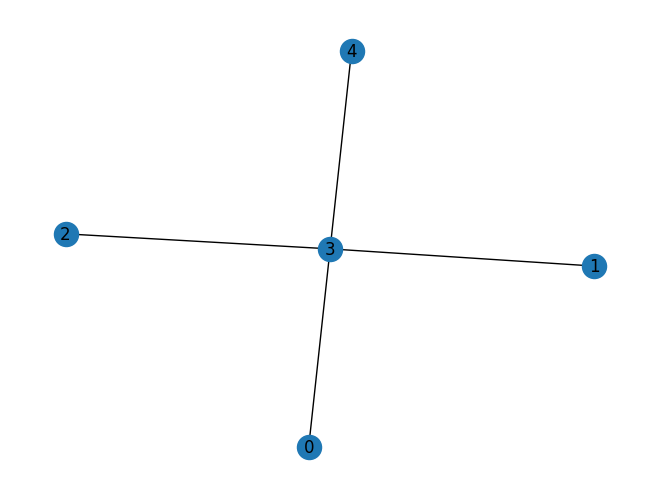

node_size 10


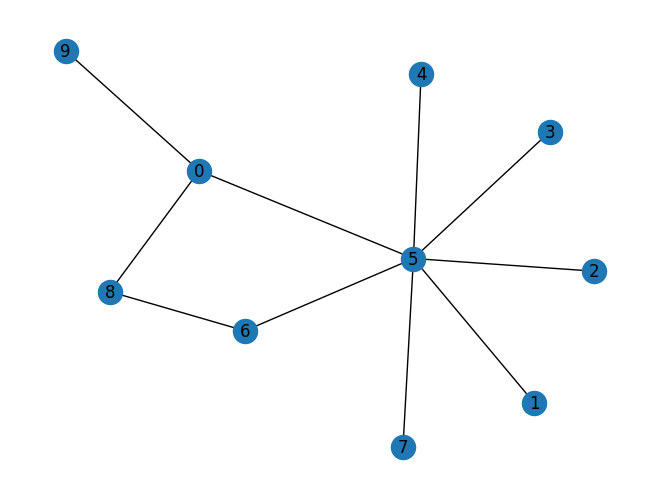

node_size 15


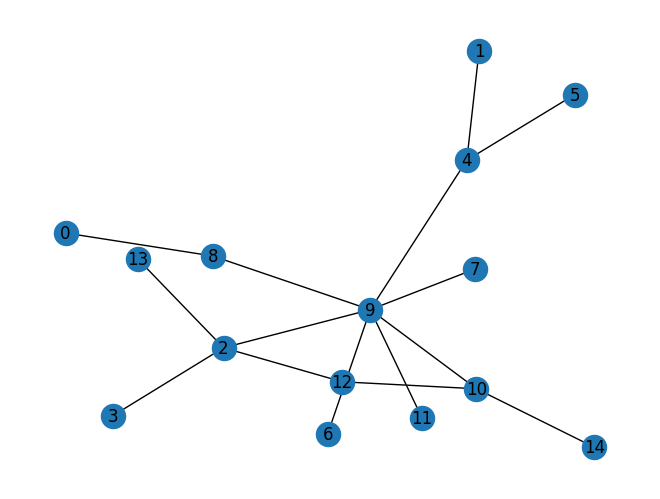

node_size 20


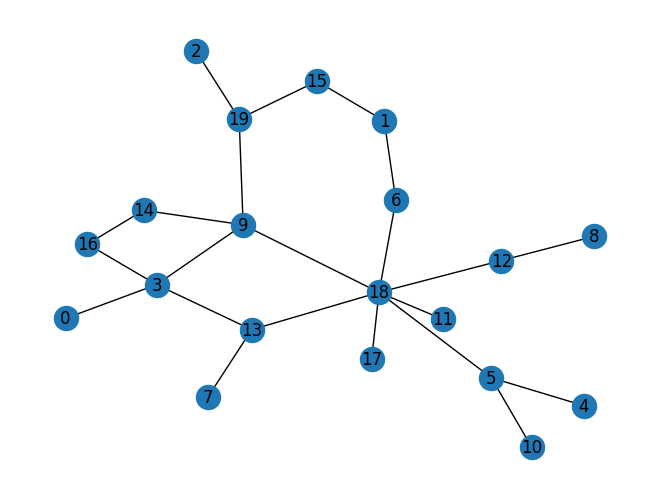

node_size 25


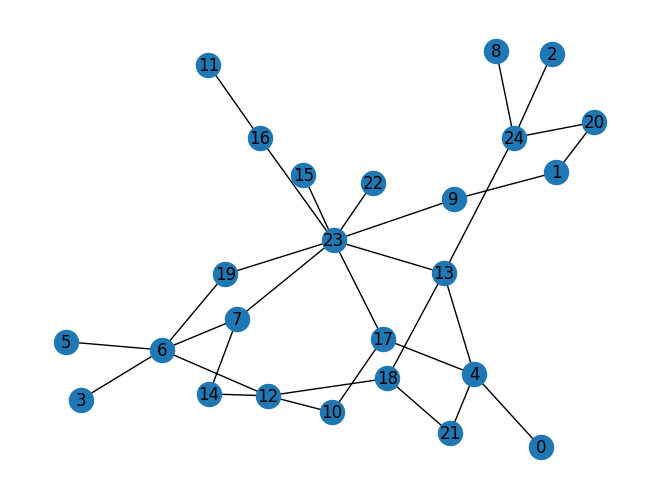

node_size 30


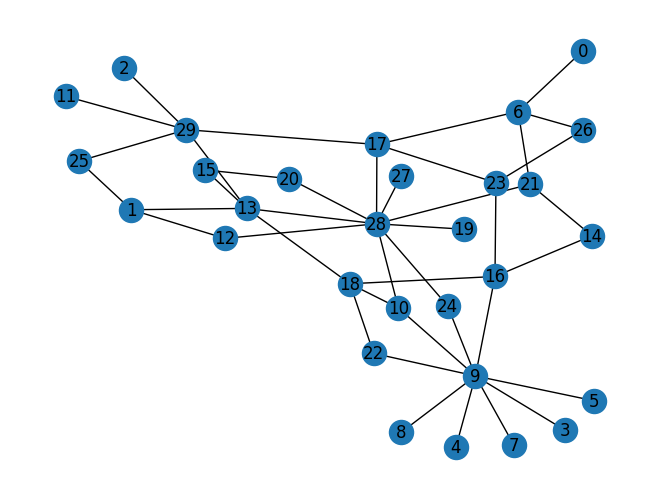

node_size 35


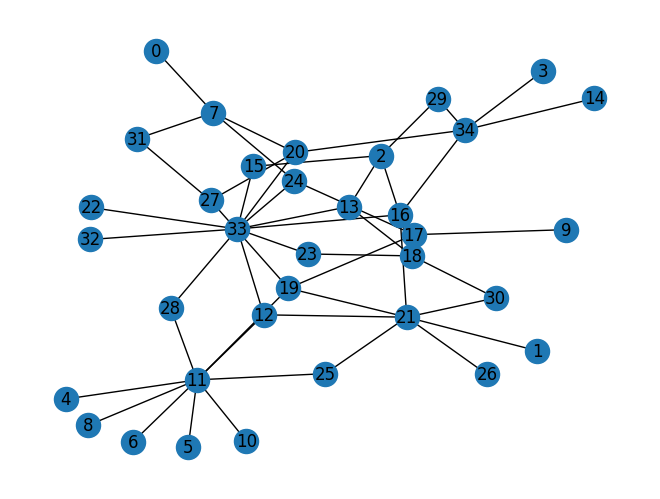

In [21]:
for g in graphs:
    print('node_size',len(g))
    nx.draw(g, with_labels = True)
    plt.show()

Plot the subgraphs 

In [22]:
# for g in graphs:
#     print(g.nodes(data=True))
#     print('new graph')  

Utility Functions

In [23]:
from torch_geometric.utils import to_dense_adj
import torch
import torch.nn.functional as F
from scipy import spatial
from scipy.special import kl_div
from sklearn import preprocessing as pre
import numpy as np
#max_nodes = 10
node_types = 4
edge_types = 1
node_classes = [0, 1, 2, 3]
device = 'cpu'
def count_parameters(model):
    """
    Counts the number of parameters for a Pytorch model
    """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def to_one_hot(x, options):
    """
    Converts a tensor of values to a one-hot vector
    based on the entries in options.
    """
    return torch.nn.functional.one_hot(x.long(), len(options))

def kl_loss(mu=None, logstd=None):
    """
    Closed formula of the KL divergence for normal distributions
    """
    MAX_LOGSTD = 10
    logstd = logstd.clamp(max=MAX_LOGSTD)
    kl_div = -0.5 * torch.mean(torch.sum(1 + 2 * logstd - mu ** 2 - logstd.exp() ** 2, dim=1))

    # Limit numeric errors
    kl_div = kl_div.clamp(max=1000)
    return kl_div


def adj_recon_loss(adj_truth, adj_pred):
    return F.binary_cross_entropy(adj_truth, adj_pred)

def node_type_loss(truth, pred):
    return spatial.distance.cosine(truth, pred)

def rescale(x):
    x = x.reshape(-1, 1)
    x_norm = pre.MinMaxScaler().fit_transform(x)
    return x_norm

def node_feature_loss(original,sampled):
    #https://stackoverflow.com/questions/11405673/python-cosine-similarity-m-n-matrices
    A = np.array(rescale(original), dtype=object)
    B = np.array(rescale(sampled), dtype=object)

    Aflat = np.hstack(A)
    Bflat = np.hstack(B)

    return spatial.distance.cosine(Aflat, Bflat)
    #return kl_div(rescale(original),rescale(sampled))

def triu_to_dense(triu_values, num_nodes):
    """
    Converts a triangular upper part of a matrix as flat vector
    to a squared adjacency matrix with a specific size (num_nodes).
    """
    dense_adj = torch.zeros((num_nodes, num_nodes)).to(device).float()
    triu_indices = torch.triu_indices(num_nodes, num_nodes, offset=1)
    tril_indices = torch.tril_indices(num_nodes, num_nodes, offset=-1)
    dense_adj[triu_indices[0], triu_indices[1]] = triu_values
    dense_adj[tril_indices[0], tril_indices[1]] = triu_values
    return dense_adj

def get_adjacency(triu_logits,max_nodes):
    # Reshape triu predictions
    edge_matrix_shape = (int((max_nodes * (max_nodes - 1)) / 2), edge_types + 1)
    triu_preds_matrix = triu_logits.reshape(edge_matrix_shape)
    triu_preds = torch.argmax(triu_preds_matrix, dim=1)
    adjacency_matrix = triu_to_dense(triu_preds.float(), max_nodes)
    return adjacency_matrix

def get_nodetype(node_logits,max_nodes):
    node_matrix_shape = (max_nodes, node_types)
    node_preds_matrix = node_logits.reshape(node_matrix_shape)
    node_preds = torch.argmax(node_preds_matrix[:, :4], dim=1)

    # Get node classes
    node_preds_one_hot = to_one_hot(node_preds, options=node_classes)
    node_classes_dummy = torch.Tensor(node_classes).repeat(node_preds_one_hot.shape[0], 1)
    node_class = torch.masked_select(node_classes_dummy, node_preds_one_hot.bool())
    return node_class

Model

In [24]:
import torch
import torch.nn as nn
from torch.nn import Linear
from torch_geometric.nn.conv import TransformerConv
from torch_geometric.nn import Set2Set
from torch_geometric.nn import BatchNorm



node_types = 4
edge_types = 1
node_classes = [0, 1, 2, 3]
class GraphVAE(nn.Module):
    def __init__(self, feature_size, nodesize):
        super(GraphVAE, self).__init__()
        self.encoder_embedding_size = nodesize
        self.edge_dim = 1
        self.latent_embedding_size = 64
        self.num_edge_types = 1
        self.num_node_types = 4
        self.max_nodes = nodesize
        self.decoder_hidden_neurons = 512
        self.feature_size = feature_size
        # Encoder layers
        self.conv1 = TransformerConv(feature_size,
                                    self.encoder_embedding_size,
                                    heads=4,
                                    concat=False,
                                    beta=True,
                                    #edge_dim=self.edge_dim
                                     )
        self.bn1 = BatchNorm(self.encoder_embedding_size)
        self.conv2 = TransformerConv(self.encoder_embedding_size,
                                    self.encoder_embedding_size,
                                    heads=4,
                                    concat=False,
                                    beta=True,
                                    #edge_dim=self.edge_dim
                                     )
        self.bn2 = BatchNorm(self.encoder_embedding_size)
        self.conv3 = TransformerConv(self.encoder_embedding_size,
                                    self.encoder_embedding_size,
                                    heads=4,
                                    concat=False,
                                    beta=True,
                                    #edge_dim=self.edge_dim
                                     )
        self.bn3 = BatchNorm(self.encoder_embedding_size)
        self.conv4 = TransformerConv(self.encoder_embedding_size,
                                    self.encoder_embedding_size,
                                    heads=4,
                                    concat=False,
                                    beta=True,
                                    #edge_dim=self.edge_dim
                                     )

        # Pooling layers
        #pools individual node feature vectors into a global graph level vector
        #self.pooling = Set2Set(self.encoder_embedding_size, processing_steps=10)

        # Linear layer1   # Mu
        # Linear Layer2  # Log var
        self.mu_transform = Linear(self.encoder_embedding_size,
                                            self.latent_embedding_size)
        self.logvar_transform = Linear(self.encoder_embedding_size,
                                            self.latent_embedding_size)

        # Decoder layers
        # Linear 1
        # Linear 2
        #Linear Layer3 #Decode nodes
        # Linear Layer4 #Decode edges

        self.linear_1 = Linear(self.latent_embedding_size, self.decoder_hidden_neurons)
        self.linear_2 = Linear(self.decoder_hidden_neurons, self.decoder_hidden_neurons)

        # --- Atom decoding (outputs a matrix: (max_num_atoms) * (# atom_types + "none"-type))
        atom_output_dim = self.max_nodes*self.num_node_types
        self.atom_decode = Linear(self.decoder_hidden_neurons, atom_output_dim)

        # --- Edge decoding (outputs a triu tensor: (max_num_atoms*(max_num_atoms-1)/2*(#edge_types + 1) ))
        edge_output_dim = int(((self.max_nodes * (self.max_nodes - 1)) / 2) * (self.num_edge_types + 1))
        self.edge_decode = Linear(self.decoder_hidden_neurons, edge_output_dim)

        node_feature_dim = self.max_nodes*self.feature_size
        self.node_feature_decode = Linear(self.decoder_hidden_neurons, node_feature_dim)


    def encode(self, x, edge_index, batch_index):
        # GNN layers
        x = self.conv1(x, edge_index).relu()
        x = self.bn1(x)
        x = self.conv2(x, edge_index).relu()
        x = self.bn2(x)
        x = self.conv3(x, edge_index).relu()
        x = self.bn3(x)
        x = self.conv4(x, edge_index).relu()

        # Pool to global representation
        #x = self.pooling(x, batch_index)

        # Latent transform layers
        mu = self.mu_transform(x)
        logvar = self.logvar_transform(x)
        return mu, logvar

    def decode_graph(self, graph_z):
        """
        Decodes a latent vector into a continuous graph representation
        consisting of node types and edge types.
        """
        # Pass through shared layers
        z = self.linear_1(graph_z).relu()
        z = self.linear_2(z).relu()
        # Decode atom types
        atom_logits = self.atom_decode(z)
        # Decode edge types
        edge_logits = self.edge_decode(z)
        # Decode edge types
        node_feature_logits = self.node_feature_decode(z)

        return atom_logits, edge_logits, node_feature_logits

    def decode(self, z, batch_index):
        node_logits = []
        triu_logits = []
        feature_logits = []

        # Iterate over molecules in batch
        for graph_id in torch.unique(batch_index):
            # Get latent vector for this graph
            graph_z = z[graph_id]

            # Recover graph from latent vector
            atom_logits, edge_logits, node_feature_logits = self.decode_graph(graph_z)

            # Store per graph results
            node_logits.append(atom_logits)
            triu_logits.append(edge_logits)
            feature_logits.append(node_feature_logits)

        # Concatenate all outputs of the batch
        node_logits = torch.cat(node_logits)
        triu_logits = torch.cat(triu_logits)
        feature_logits = torch.cat(feature_logits)
        return triu_logits, node_logits, feature_logits

    def reparameterize(self, mu, logvar):
        if self.training:
            # Get standard deviation
            std = torch.exp(logvar)
            # Returns random numbers from a normal distribution
            eps = torch.randn_like(std)
            # Return sampled values
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, edge_index, batch_index):
        # encode
        # Encode the molecule
        mu, logvar = self.encode(x, edge_index, batch_index)
        # sample
        # Sample latent vector (per atom)
        z = self.reparameterize(mu, logvar)
        # decode
        # Decode latent vector into original molecule
        triu_logits, node_logits, feature_logits= self.decode(z, batch_index)

        return triu_logits, node_logits, feature_logits,mu, logvar


    def sample_graph(self, nodes):
        z = torch.randn(1, self.latent_embedding_size)
        # Get model output (this could also be batched)
        dummy_batch_index = torch.Tensor([0]).int()
        triu_logits, node_logits, feature_logits= self.decode(z, dummy_batch_index)

        # Reshape triu predictions
        edge_matrix_shape = (int((nodes * (nodes - 1)) / 2), edge_types + 1)
        triu_preds_matrix = triu_logits.reshape(edge_matrix_shape)
        triu_preds = torch.argmax(triu_preds_matrix, dim=1)

        # Reshape node predictions
        node_matrix_shape = (nodes, node_types)
        node_preds_matrix = node_logits.reshape(node_matrix_shape)
        node_preds = torch.argmax(node_preds_matrix[:, :4], dim=1)

        # Get node classes
        node_preds_one_hot = to_one_hot(node_preds, options=node_classes)
        node_classes_dummy = torch.Tensor(node_classes).repeat(node_preds_one_hot.shape[0], 1)
        node_class = torch.masked_select(node_classes_dummy, node_preds_one_hot.bool())
        #print('node_types', node_class.type(torch.int64).numpy())
        #print('node feature matrix', feature_logits.reshape(nodes,200))
        # print('triu_preds',triu_preds.float())
        adjacency_matrix = triu_to_dense(triu_preds.float(), nodes)
        #print('adj', adjacency_matrix)
        return adjacency_matrix, node_class,feature_logits.reshape(self.max_nodes, self.feature_size)
    
        #plot_graph(adjacency_matrix.numpy(),node_class.type(torch.int64).numpy())


Data Preparation

In [25]:
import torch
import networkx as nx
import pandas as pd
import numpy as np

def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))

def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]]
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

def dataset(graph):
    orig_adj = nx.adjacency_matrix(graph).todense()
    # nx.draw(new_graph, with_labels=True)
    # plt.show()

    node_data = graph.nodes(data=True)

    feature = []
    node_type = []
    node_id = []
    for key, value in node_data:
        node_id.append(key)
        print(value)
        feature.append(value['feature'])
        node_type.append(value['node_type'])

    df = pd.DataFrame()
    df["node_id"] = node_id
    df["feature"] = feature
    df["node_type"] = node_type

    df_feature = df["feature"]
    node_features = torch.tensor(df_feature).float()
    nodes_mapping = remap_indices(list(df["node_id"]))
    edges = graph.edges()
    edge_index = preprocess_edges(edges, nodes_mapping)

    return {'x': node_features,
            'node_type_orig': node_type,
            'edge_index': edge_index,
            'orig_adj': orig_adj
            }

Plot generated graphs with node types

In [26]:
def plot(G,classes):

    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}

    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')

    nx.draw(G, 
        with_labels=True, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            #node_size=800,
        font_color='white')
    plt.show()       

In [27]:
small_graph_dict = []
def postprocess(real_adj,sync_adj,classes,node_features):
    
    node_features = node_features.detach().numpy()
    print('type', node_features.shape)
    #counter = 0
    real_G = nx.from_numpy_array(real_adj)
    list_realedges = list(real_G.edges())
    
    sync_G = nx.from_numpy_array(sync_adj)
    list_syncedges = list(sync_G.edges())
    
    new_graph =[]
    for edge in list_syncedges:
    #print(i)
        if edge in list_realedges:
            #print(edge)
            
            new_graph.append(edge)
            
    new_G = nx.from_edgelist(new_graph) 
    real_node_list = list(real_G.nodes())
    syn_node_list = list(new_G.nodes())
    #Get the nodes removed from real node list
    nodes_removed = []
    for element in real_node_list:
        if element not in syn_node_list:
            nodes_removed.append(element)
            
    index_list =[]
    for i in nodes_removed:
        index_list.append(real_node_list.index(i))
    print('index_list',index_list)
    #remove rows from the same index in class and node feature list
    if index_list:
        classes = np.delete(classes, index_list)
        node_features = np.delete(node_features, index_list, axis=0)
        print('new_type', node_features.shape)
    
    if not nx.is_empty(new_G) and nx.is_connected(new_G):
        print('node types',classes)
        print('nodes',new_G.number_of_nodes())
        print('node_features',node_features.shape)
        #print('adj',sync_adj)
        save_syn_graphs(new_G,torch.tensor(node_features),classes,new_G.number_of_nodes(),"sync"+str(random.randint(1, 1000000))+time.strftime("%H%M%S"))
        plot(new_G,classes)
        small_graph_dict.append({'graph':new_G,'classes':classes,'node_features':node_features})

In [29]:
def save_real_graphs(graph,node_feature,classes,max_num_nodes,real):
        graph_path = "real_vae/dblp/graphs/"
        node_feat_path = "real_vae/dblp/node_features/"
        node_class_path = "real_vae/dblp/node_classes/"
#         #save graph
        nx.write_gexf(graph, graph_path+real+"_G"+str(max_num_nodes)+".gexf")
        #save nodefeature
        torch.save(node_feature, node_feat_path+real+"_node_features"+str(max_num_nodes)+".pt") 
        #save node classes
        torch.save(torch.tensor(classes), node_class_path+real+"_node_class"+str(max_num_nodes)+".pt") 


In [30]:
def save_syn_graphs(graph,node_feature,classes,max_num_nodes,real):
        graph_path = "syn_vae/dblp/"+real
        os.makedirs(graph_path)
#         graph_path = "graphs/syn/vae/pubmed/"
#         node_feat_path = "node_features/syn/vae/pubmed/"
#         node_class_path = "node_classes/syn/vae/pubmed/"
#         #save graph
        nx.write_gexf(graph, graph_path+'/'+real+"_G"+str(max_num_nodes)+".gexf")
        #save nodefeature
        torch.save(node_feature, graph_path+'/'+real+"_node_features"+str(max_num_nodes)+".pt") 
        #save node classes
        torch.save(torch.tensor(classes), graph_path+'/'+real+"_node_class"+str(max_num_nodes)+".pt") 

Train

In [ ]:
import pandas as pd
import torch
import numpy as np
import networkx as nx
from littleballoffur import ForestFireSampler
import matplotlib.pyplot as plt
import csv
import shutil
import os


node_types = 4
edge_types = 1
node_classes = [0, 1, 2, 3]
feature_size = 50
def train(type, epoch, nodesize, model, data):
    x = data['x']
    node_type_orig = data['node_type_orig']
    edge_index = data['edge_index']
    orig_adj = data['orig_adj']

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    optimizer.zero_grad()
    # Call model
    batch_index = torch.Tensor([0]).int()
    triu_logits, node_logits, feature_logits, mu, logvar = model(x.float(),
                                                                 edge_index, batch_index)

    # Calculate loss
    # graph loss
    pred_adj = get_adjacency(triu_logits, nodesize)
    graph_loss = adj_recon_loss(torch.Tensor(orig_adj), pred_adj)

    # node type loss
    node_type_pred = get_nodetype(node_logits,nodesize)
    nodetype_loss = node_type_loss(node_type_orig, node_type_pred)

    # node feature loss
    feature_loss = node_feature_loss(x.float().detach().numpy(),
                                     feature_logits.reshape(nodesize, feature_size).detach().numpy())
    # print('feature_loss',feature_loss)

    kldiv_loss = kl_loss(mu, logvar)

    # Add node feature loss, node type loss
    loss = graph_loss + nodetype_loss + feature_loss + kldiv_loss
    print('epoch:', epoch, 'graph_loss:', graph_loss, 'nodetype_loss:', nodetype_loss, 'feature_loss', feature_loss,
          'kldiv_loss:', kldiv_loss, 'loss:', loss)
    if type == "Train":
        loss.backward()
        optimizer.step()

    # Perform sampling
    if type == "Test":
        sync_adj, sync_classes, node_features = model.sample_graph(nodesize)
        postprocess(orig_adj, sync_adj.numpy(),sync_classes.type(torch.int64).numpy(),node_features)
        

def main():

    for g in graphs:
        max_num_nodes = g.number_of_nodes()

        print('max number node: {}'.format(max_num_nodes))
        #create dataset
        data = dataset(g)
        #build model
        model = GraphVAE(feature_size=50,nodesize=max_num_nodes)
        #Plot original graph
        print('------------------Plot of Real Graph------------------------')
        orig_classes = data['node_type_orig']
        real_G = nx.from_numpy_array(data['orig_adj'])
        
#         graph_path = "vae_graphs/pubmed/"
#         node_feat_path = "vae_node_features/pubmed/"
#         node_class_path = "vae_node_classes/pubmed/"
        
        #nx.write_gexf(real_G, graph_path+"real_G"+str(max_num_nodes)+".gexf")           
        #torch.save(data['x'], node_feat_path+"real_node_features"+str(max_num_nodes)+".pt") 
        #torch.save(torch.tensor(data['node_type_orig']), node_class_path+"real_node_class"+str(max_num_nodes)+".pt") 
        save_real_graphs(real_G,data['x'],orig_classes,max_num_nodes,"real") 
        plot(real_G, orig_classes)
        print('------------------Plot of Synthetic Graphs------------------------')
        for epoch in range(2000):
            model.train()
            train(type="Train",epoch=epoch,nodesize=max_num_nodes,model=model,data=data)

            if epoch % 5 == 0:
                #print("Start test epoch...")
                model.eval()
                train(type="Test",epoch=epoch,nodesize=max_num_nodes,model=model,data=data)

if __name__ == '__main__':
    main()

In [ ]:
small_graph_dict